In [40]:
# necessary imports
import helper.training_preprocess as tp
import helper.eval_worker as ew
from models.bnn import BNN
import numpy as np
import torch

In [41]:
bnn_presaved = True
model_filename = '10k_0.2TRAJ_5MNOISE_64H_bnn_model_2024-12-17_20-59-18.pth'
model_fileprefix = "10k_0.2TRAJ_5MNOISE_64H"
train_sensor_measurement_uncertainty = 5
train_epochs = 10000
training_traj_percent = 0.2

In [42]:
columns_of_interest_dict = tp.export_preproc_var_columns()
x_columns_of_interest = columns_of_interest_dict['x_columns_of_interest']
y_columns_of_interest = columns_of_interest_dict['y_columns_of_interest']
z_obs_columns = columns_of_interest_dict['z_obs_columns']

In [44]:
train_df, test_df_holdout, train_traj_data, test_traj_data_holdout = tp.readin_dataframes(train_split=training_traj_percent, sensor_pos_uncer=train_sensor_measurement_uncertainty)

Number of Train Trajectories: 1019
Number of Test Trajectories: 4074


In [45]:
display(train_df)

,timestamp,tx,ty,tz,vx,vy,vz,tx_measured,ty_measured,tz_measured,vx_measured,vy_measured,vz_measured,sigma_pos,sigma_vel,tx_measured_plus,ty_measured_plus,tz_measured_plus,delta_time
0,0.000000,-20.110498,2.792424,17.071516,0.827515,-0.114170,0.334543,-16.953761,1.098420,12.645976,0.827359,-0.105106,0.329130,5,0.005,-20.070249,2.394119,17.583043,0.100000
1,0.100000,-20.027747,2.781007,17.104970,0.687851,-0.017778,0.435271,-20.070249,2.394119,17.583043,0.688836,-0.024749,0.432235,5,0.005,-22.634136,4.729901,18.389995,0.100000
2,0.200000,-19.958962,2.779229,17.148497,0.606798,0.254735,0.726220,-22.634136,4.729901,18.389995,0.614248,0.258953,0.730604,5,0.005,-16.678309,6.858629,23.449610,0.100000
3,0.300000,-19.898282,2.804703,17.221119,0.404264,0.639850,0.534433,-16.678309,6.858629,23.449610,0.412101,0.638872,0.530521,5,0.005,-23.006299,-0.133315,19.073258,0.100000
4,0.400000,-19.857856,2.868688,17.274563,0.153350,1.112576,0.332398,-23.006299,-0.133315,19.073258,0.149637,1.101241,0.335262,5,0.005,-7.807810,0.282695,14.529721,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175297,23.499977,4.453098,13.423450,12.530015,3.241870,-2.221316,-0.090775,0.349364,10.269410,7.142029,3.230903,-2.214941,-0.095745,5,0.005,8.006741,11.129182,20.799965,0.100000
175298,23.599977,4.777287,13.201317,12.520938,3.255944,-2.093330,-0.054121,8.006741,11.129182,20.799965,3.263643,-2.102999,-0.056203,5,0.005,-2.014717,15.462915,8.815019,0.100000
175299,23.699978,5.102882,12.991984,12.515526,3.767415,-2.309667,-0.058740,-2.014717,15.462915,8.815019,3.768100,-2.311000,-0.069342,5,0.005,13.570141,21.246395,13.210309,0.099998
175300,23.799976,5.479618,12.761021,12.509652,3.653508,-2.127211,-0.076890,13.570141,21.246395,13.210309,3.651861,-2.126293,-0.086863,5,0.005,2.835120,9.855676,20.313954,0.100000


In [46]:
display(test_df_holdout)

,timestamp,tx,ty,tz,vx,vy,vz,tx_measured,ty_measured,tz_measured,vx_measured,vy_measured,vz_measured,sigma_pos,sigma_vel,tx_measured_plus,ty_measured_plus,tz_measured_plus,delta_time
0,0.000000,8.275681,26.549759,7.497171,-0.442434,0.043865,-0.453622,10.612595,28.166139,8.869257,-0.443209,0.038151,-0.456918,5,0.005,7.433444,27.212712,-2.100882,0.100000
1,0.100000,8.231438,26.554145,7.451809,-0.519214,-0.091192,-0.171525,7.433444,27.212712,-2.100882,-0.509393,-0.089081,-0.171874,5,0.005,0.982734,30.631518,16.090670,0.100000
2,0.200000,8.179517,26.545026,7.434656,-0.929391,-0.068917,-0.069919,0.982734,30.631518,16.090670,-0.925965,-0.065573,-0.073432,5,0.005,8.821192,24.487001,16.403022,0.100000
3,0.300000,8.086578,26.538134,7.427664,-1.240382,0.011767,-0.109389,8.821192,24.487001,16.403022,-1.238966,0.009376,-0.104130,5,0.005,13.479048,20.463086,-7.197470,0.100000
4,0.400000,7.962540,26.539311,7.416726,-1.633285,0.160277,-0.131733,13.479048,20.463086,-7.197470,-1.635773,0.173536,-0.131268,5,0.005,9.313731,35.779936,8.527507,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590833,11.399989,-31.410724,-2.445097,5.099618,-2.817649,-2.408035,-0.115101,-37.071656,1.070370,7.600478,-2.817802,-2.401167,-0.118081,5,0.005,-27.843968,-3.568871,5.618723,0.099999
590834,11.499989,-31.692487,-2.685899,5.088108,-2.732949,-2.156075,-0.068056,-27.843968,-3.568871,5.618723,-2.732276,-2.152939,-0.073607,5,0.005,-29.424819,-5.194920,-1.054690,0.100000
590835,11.599989,-31.965783,-2.901507,5.081302,-3.040037,-2.226045,-0.004532,-29.424819,-5.194920,-1.054690,-3.036804,-2.225039,0.006333,5,0.005,-33.388292,-5.694895,11.674932,0.100000
590836,11.699989,-32.269788,-3.124112,5.080849,-2.856681,-1.939021,0.032186,-33.388292,-5.694895,11.674932,-2.846047,-1.935923,0.041222,5,0.005,-42.889903,-5.098226,4.624708,0.099999


In [47]:
# sanity check
print(len(train_df)/(len(test_df_holdout) + len(train_df)))

0.22881196648132196


In [48]:
X_train, y_train, df_cleaned_train = tp.preprocess_and_remove_inter_trajectory_indices(train_df)
X_test, y_test, df_cleaned_test = tp.preprocess_and_remove_inter_trajectory_indices(test_df_holdout)

 Epoch: 10000/10000 | Loss:  14.19 

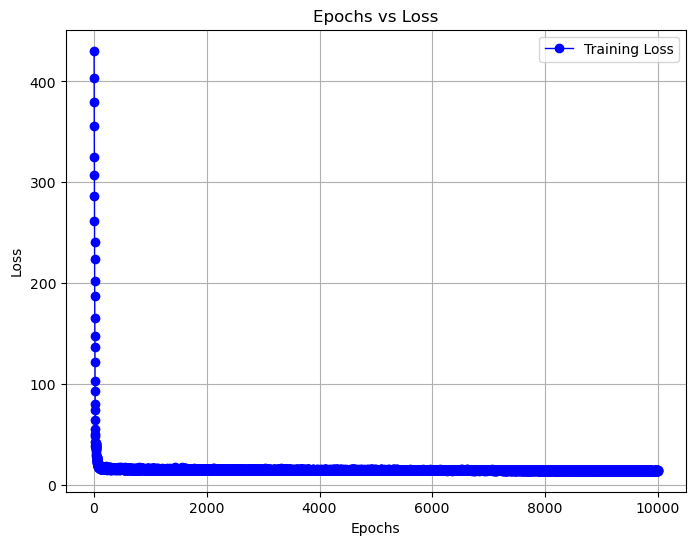

Model weights saved to ../../models/saved_weights/bnn\10k_0.2TRAJ_5MNOISE_64H_bnn_model_2024-12-17_20-59-18.pth
Done loading/training!
CPU times: total: 7h 14min 45s
Wall time: 1h 13min 15s


In [49]:
%%time
if bnn_presaved:
    bnn_model = BNN(input_size=len(x_columns_of_interest), output_size=len(y_columns_of_interest), hidden_layer_size=64, prior_sigma_lay=0.01, epochs=train_epochs, show_info=True)
    bnn_model.load_model_weights(f'../../models/saved_weights/bnn/{model_filename}')
else:
    bnn_model = BNN(input_size=len(x_columns_of_interest), output_size=len(y_columns_of_interest), hidden_layer_size=64, prior_sigma_lay=0.01, epochs=train_epochs, show_info=True)
    bnn_model.fit(X_train, y_train)
    bnn_model.plot()
    bnn_model.save_model_weights(file_prefix=model_fileprefix, directory='../../models/saved_weights/bnn')

print('Done loading/training!')

In [50]:
z_obs_test = torch.tensor(df_cleaned_test[z_obs_columns][:-1].to_numpy(), dtype=torch.float32)

In [51]:
%%time
avg_bnn_model_err, avg_bnn_model_uncertainty, bnn_model_proposed_traj = ew.evaluate_bayesian_neural_model(bnn_model, df_cleaned_test, X_test, y_test, z_obs_test, pinn_eval=False, apply_EKF_in=False, continuous_eval=False)

 32%|███▏      | 186367/586763 [32:26<1:09:40, 95.77it/s] 

KeyboardInterrupt



In [52]:
print(np.mean(avg_bnn_model_err))
print(np.mean(avg_bnn_model_uncertainty))

5.7229767
0.4149841


## 10M UNCERT
9.4 ERR, 0.39 UNCER